In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla

np.set_printoptions(linewidth=130)

In [2]:
from fsmfuncs import *
from ibmfuncs import *
from gridfuncs import *

Numerical grid for the fluid

In [3]:
s1 = stretching(256, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
s2 = stretching(128, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
x = np.concatenate([-s2[::-1], s1[1:]])
s = stretching(192, 0.033, 0.20, int(0.65/0.033), 16, 16, 0.04)[0]
y = np.concatenate([-s[::-1], s[1:]])

n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[1:-1], xp
v = np.zeros( (n-1, m) )

Immersed boundary

In [4]:
r_ = 0.5
l = int((2*np.pi*r_)/dxmin)
ang_ = 2*np.pi*np.arange(l)/l
xi = 0 + r_*np.cos(ang_)
eta = 0 + r_*np.sin(ang_)
ds = 2*np.pi*r_/l*np.ones(l)
uB = np.zeros_like(xi)
vB = np.zeros_like(xi)

Plot grid and immersed boundary

(-2, 2)

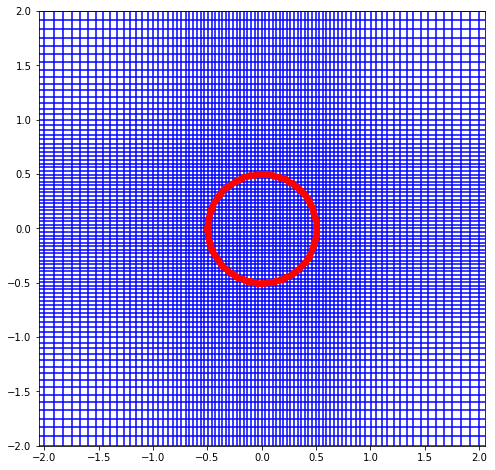

In [8]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-')
plt.plot(X.T, Y.T, 'b-')
plt.plot(xi, eta, 'ro-')
plt.axis('equal');
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [9]:
uS, uN = np.ones(m-1), np.ones(m-1)
uE, uW = np.ones(n), np.ones(n)

vS, vN = np.zeros(m), np.zeros(m)
vE, vW = np.zeros(n-1), np.zeros(n-1)

u[:,:]=1
v[:,:]=0

Build matrices (I)

In [10]:
G, DuW, DuE, DvS, DvN = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dxp, dyp)
Lh, Lux0, Lux1, Luy0, Luy1, Lvx0, Lvx1, Lvy0, Lvy1 = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

Build matrices (II)

In [11]:
iRe = 1/200.0
dt = 0.40 * min(dxmin**2/iRe, dxmin)
print(dt, dxmin**2/iRe, dxmin)

0.0132 0.2178 0.033


In [12]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [13]:
q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q),  uS, uN, uW, uE, vS, vN, vW, vE)
Nu, Nv = Num1, Nvm1

In [14]:
nt = int(100/dt)
print("Performing", nt, "steps")

residuals = np.zeros(nt)
CFx = np.zeros(nt)
CFy = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE) + Luy0.dot(uS) + Luy1.dot(uN)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE) + Lvy0.dot(vS) + Lvy1.dot(vN)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 = - (DuW.dot(uW*dy) + DuE.dot(uE*dy) + DvS.dot(vS*dx) + DvN.dot(vN*dx))
    r2 = np.concatenate([-bc2, uB, vB])

    λ = iQTBNQ(Q.T.dot(qast) - r2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    
    f = -iEH(EET.dot(λ[n*m:]))
    CFx[k], CFy[k] = -2*np.sum(f[:l]*ds), -2*np.sum(f[l:]*ds)
 
    if k%10==0:
        print(k, k*dt, residuals[k], CFx[k], CFy[k])
    
    q = qp1
    uE = uE - dt/dx[-1]*(uE - iR.dot(q)[:n*(m-1)].reshape((n, m-1))[:,-1])
    
    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uS, uN, uW, uE, vS, vN, vW, vE)

Performing 7575 steps
0 0.0 1.55007758339 264.371127211 0.00123450825407
10 0.132 0.0160918651071 1.38236722464 -0.000137113351752
20 0.264 0.0121076403897 1.16254859601 -7.69569430135e-05
30 0.396 0.01116180284 1.11348963316 -4.79717673432e-05
40 0.528 0.0109754897645 1.12755613422 -2.68121830443e-05
50 0.66 0.0110057306781 1.16829313348 -7.3424186271e-06
60 0.792 0.0110708014464 1.2180134616 1.2817805519e-05
70 0.924 0.0111029226688 1.26659644568 3.18087335463e-05
80 1.056 0.0110786155419 1.30818244777 4.74311038884e-05
90 1.188 0.0109934472315 1.33973904211 5.87530724675e-05
100 1.32 0.0108507275108 1.36031970068 6.5880211449e-05
110 1.452 0.0106564188856 1.3704917871 6.95347393017e-05
120 1.584 0.0104169911566 1.37179629837 7.05769336763e-05
130 1.716 0.0101392974578 1.36624373265 6.97928050292e-05
140 1.848 0.00983089399951 1.35589745285 6.78084923375e-05
150 1.98 0.00950007575822 1.34258828781 6.50628402882e-05
160 2.112 0.0091555298845 1.32776878956 6.18065567109e-05
170 2.244 0

KeyboardInterrupt: 

In [15]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n-1, m))
p = λ[:n*m].reshape((n,m))
f = λ[n*m:]

Display solution

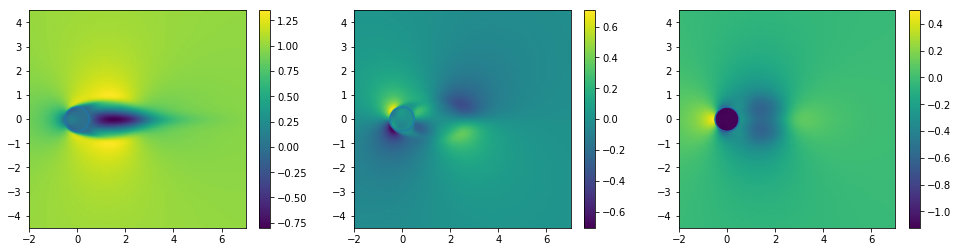

In [16]:
x0, x1 = -2, 7
y0, y1 = -4.5, 4.5
plt.figure(figsize=(5.5*3,4))
plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

95


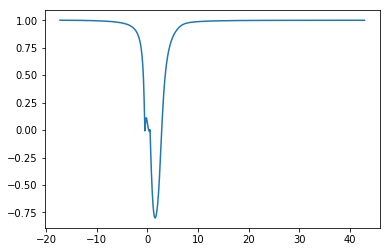

In [17]:
plt.plot(xu, u[n//2,:])
print(l)

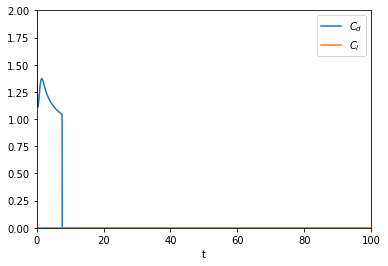

In [21]:
plt.plot(np.arange(len(CFy))*dt, CFx, label=r'$C_d$')
plt.plot(np.arange(len(CFy))*dt, CFy, label=r'$C_l$')

plt.xlim(0, 100)
plt.ylim(0, 2)
plt.xlabel('t')
plt.legend()